<a href="https://colab.research.google.com/github/ewondare/GNN/blob/main/Graph_Sage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import PPI
from sklearn.metrics import f1_score


In [ ]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 39.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 3.8 MB/s eta 0:00:00


# 1.Introduction


GraphSAGE (short for Graph SAmple and AggregGatE) is a framework for inductive representation learning on large graphs. It was introduced in a 2017 paper by Hamilton, Ying, and Leskovec. Unlike traditional graph embedding methods (e.g., DeepWalk, Node2Vec), which are transductive, GraphSAGE is inductive. This means it can generate embeddings for new nodes that were not part of the training graph.
GraphSAGE is widely used for:
- **Node classification**: Predicting labels for nodes in a graph.
- **Link prediction**: Predicting whether two nodes are likely to be connected.
- **Graph-based recommendation systems**: Generating embeddings for users and items in a recommendation graph.

It is stated in the paper that GraphSAGE handles; both supervised and unsupervised tasks. we will walk through a classification task in this notebook and also, implement the Model with a Mean Aggregator at the end of it.

## 1.1 Transductive models on Node Embeddings
Most existing approaches to generating node embeddings are inherently transductive. The majority of these approaches directly optimize the embeddings for each node using matrix-factorization-based objectives, and do not naturally generalize to unseen data, since they make predictions on nodes in a
single, fixed graph. Transductive models require that all nodes in the
graph are present during training of the embeddings and do not naturally generalize to unseen nodes.

## 1.2 Previous Works
Transductive approaches can be modified to operate in an
inductive setting but these modifications tend to be computationally expensive, requiring additional rounds of gradient descent before new predictions can be made. There are also recent approaches to learning over graph structures using convolution operators that offer promise as an embedding methodology. So far, graph convolutional networks (GCNs) have only been applied in the transductive setting with fixed graphs.


## 1.3 Present Work
In this work they both extend GCNs to the task
of inductive unsupervised learning and propose a framework that generalizes the GCN approach to use trainable aggregation functions (beyond simple convolutions).

if you're not already familiar with GCN you can check our notbook that explores the idea behind GCN and similar models to it.
https://colab.research.google.com/drive/1KLOoa53AsLaAups5wgrDo07W8WqXnDJY?usp=drive_link


## 1.4 Dataset
In the paper, The model is tested on 3 Datasets: Citation, Reddit, PPI Graphs.
The article utilizes three datasets for evaluating the performance of GraphSAGE:

*   **Citation data**: This dataset is derived from the Thomson Reuters Web of Science Core Collection and includes papers from six biology-related fields published between 2000 and 2005. The node labels represent the six different fields. The dataset contains 302,424 nodes with an average degree of 9.15. The algorithm is trained on data from 2000-2004 and tested on 2005 data. Node degrees and processed paper abstracts are used as features, with the abstracts processed using Arora et al.'s sentence embedding approach and 300-dimensional word vectors trained with the GenSim word2vec implementation.
*   **Reddit data**: This dataset is constructed from Reddit posts made in September 2014. The node label indicates the community, or "subreddit," to which a post belongs. A post-to-post graph is created by connecting posts if the same user comments on both. The dataset comprises 232,965 posts with an average degree of 492. The first 20 days of data are used for training, and the remaining days for testing. Features include concatenated 300-dimensional GloVe CommonCrawl word vectors for the post title and comments, the post's score, and the number of comments on the post.
*   **Protein-protein interaction (PPI) graphs**: This dataset is used to assess generalization across graphs and classifies protein roles based on their cellular functions from gene ontology. Each graph corresponds to a different human tissue. Positional gene sets, motif gene sets, and immunological signatures are used as features, while gene ontology sets are used as labels (121 in total). The average graph contains 2373 nodes with an average degree of 28.8. The algorithms are trained on 20 graphs and tested on two separate graphs, with another two used for validation. The full datasets for PPI and Reddit are available online.




In this nootbook, we'll see an implementation on a dataset with 20k nodes, named PubMed. PubMed is part of the Planetoid dataset (MIT license). Here’s a quick summary:

- It contains 19,717 scientific publications about diabetes from PubMed’s database
Node features are TF-IDF weighted word vectors with 500 dimensions, which is an efficient way of summarizing documents without transformers.

- The task is quite straightforward since it’s a multi-class classification with three categories: diabetes mellitus experimental, diabetes mellitus type 1, and diabetes mellitus type 2.

In [ ]:
import torch
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...
Done!


Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


# 2.Graph Sage Model Overview
They propose a general framework, called GraphSAGE (SAmple and aggreGatE), for
inductive node embedding. Unlike embedding approaches that are based on matrix factorization, we leverage node features (e.g., text attributes, node profile information, node degrees) in order to learn an embedding function that generalizes to unseen nodes.

![link text](https://snap.stanford.edu/graphsage/sample_and_agg.png)

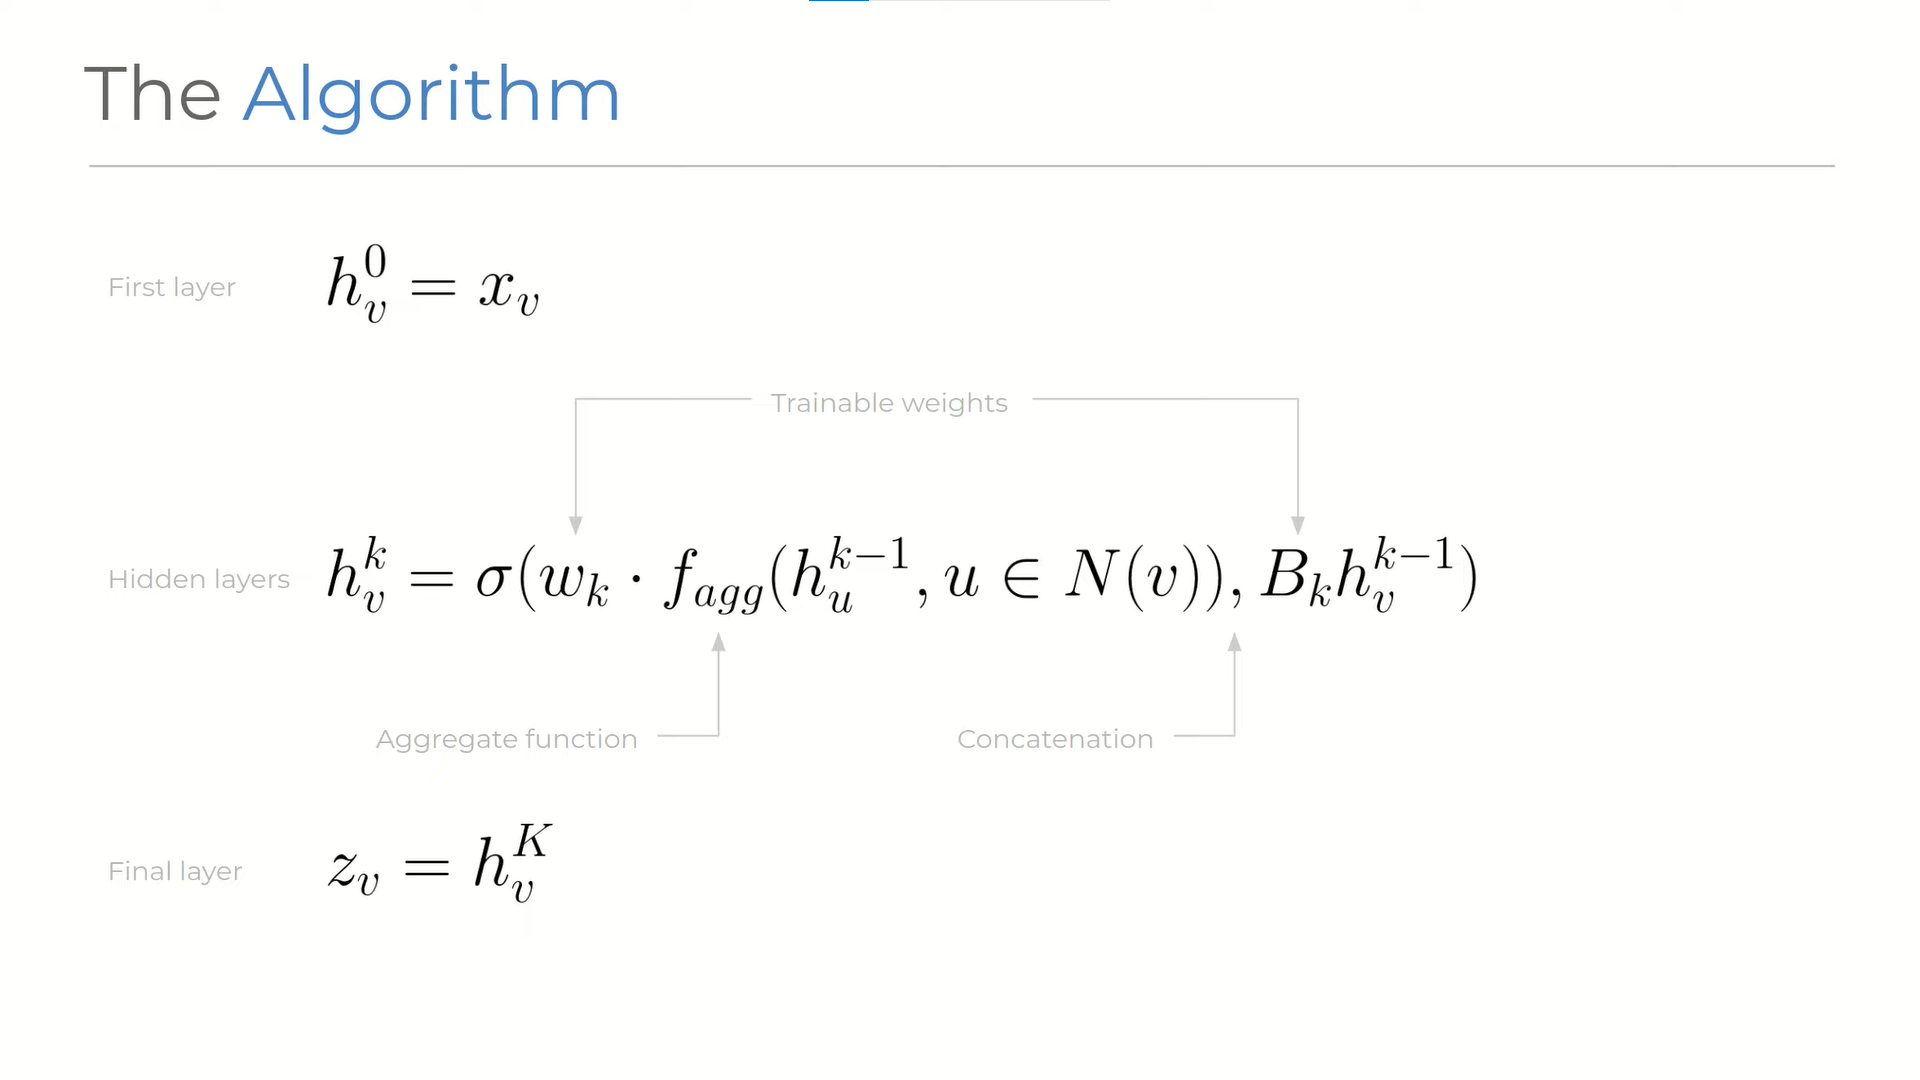

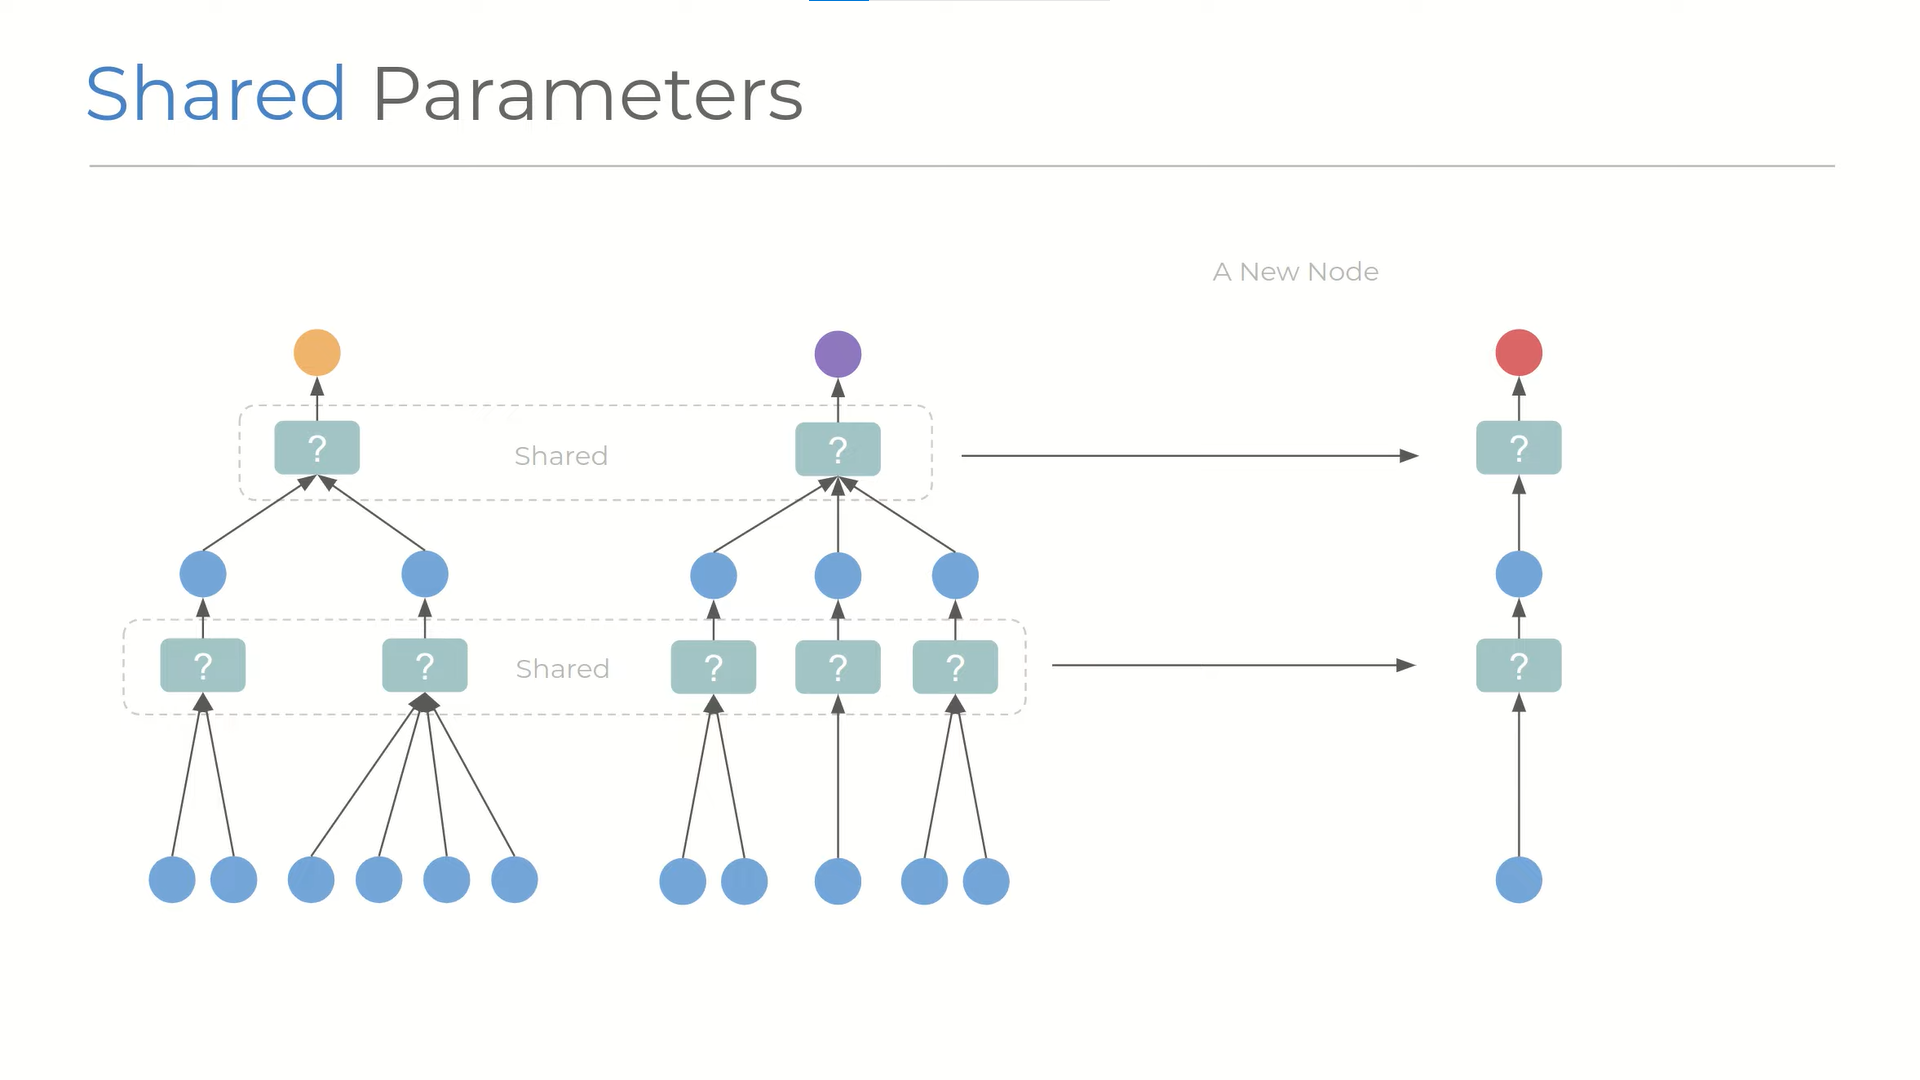

## 2.1 Embedding generation (i.e., forward propagation) algorithm
In this section, we describe the embedding generation, or forward propagation algorithm (Algorithm 1), which assumes that the model has already been trained and that the parameters are fixed. In particular, we assume that we have learned the parameters of $ K $ aggregator functions denoted: $$\text{AGGREGATE}_k, \forall k \in \{1, \dots, K\}$$ which aggregate information from node neighbors, as well as a set of weight matrices $$\mathbf{W}^k, \forall k \in \{1, \dots, K\}$$ which are used to propagate information between different layers of the model or "search depths".


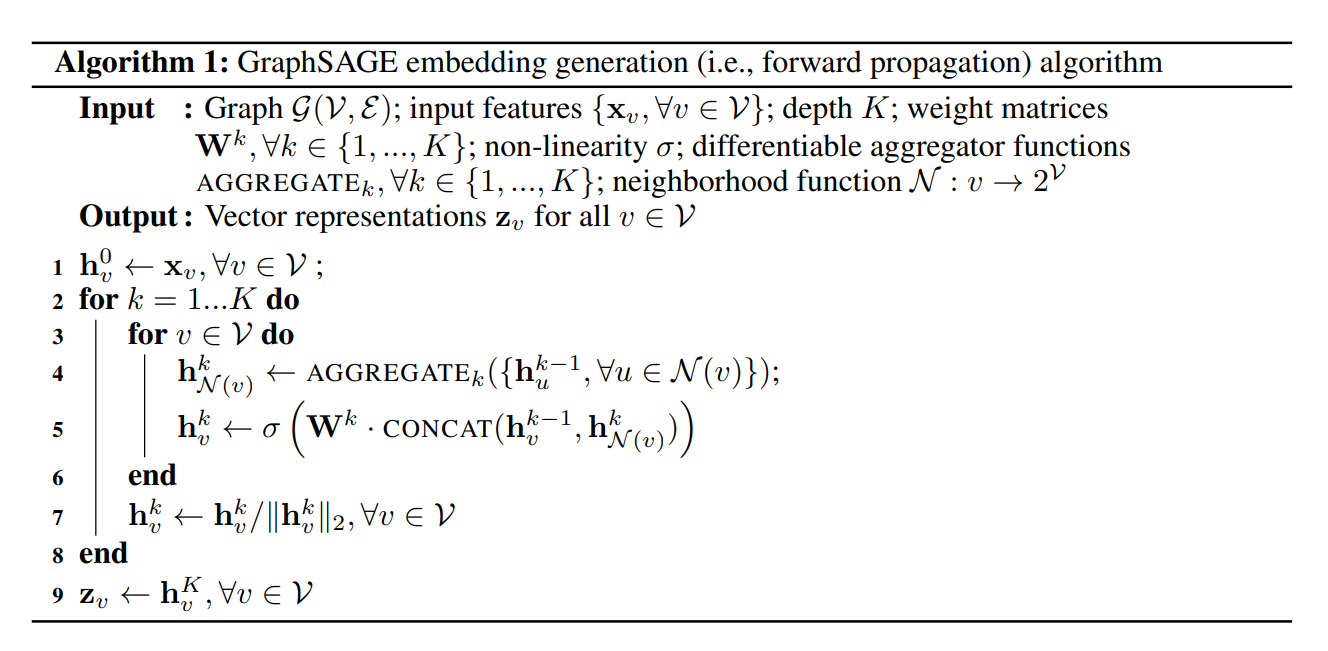

However, in the paper they use a  uniformly sample a fixed-size set of neighbors, instead of using full neighborhood sets in Algorithm 1, in order to keep the computational footprint of each batch fixed.
That is, using overloaded notation, we define $\mathcal{N}(v)$ as a fixed-size, uniform draw from the set $\{u \in \mathcal{V} : (u,v) \in \mathcal{E}\}$, and we draw different uniform samples at each iteration, $k$, in Algorithm 1.

Without this sampling, the memory and expected runtime of a single batch is unpredictable and in the worst case $O(|\mathcal{V}|)$. In contrast, the per-batch space and time complexity for GraphSAGE is fixed at $O\left(\prod_{i=1}^{K} S_i\right)$, where $S_i, i \in \{1,\dots,K\}$ and $K$ are user-specified constants. Practically speaking, we found that our approach could achieve high performance with $K = 2$ and $S_1 \cdot S_2 \leq 500$.

Therefore, the training part includes 2 steps.
1. Sampling (How many of neighbours should we visit and count their aggregation function)
2. Aggregation (You will see more about this part in section 2.2)


In the following code segment we will see how the Sampler works.

Neighbor sampling considers only a fixed number of random neighbors. Here’s the process:

The sampler randomly selects a defined number of neighbors (1 hop), neighbors of neighbors (2 hops), etc. we would like to have
The sampler outputs a subgraph containing the target and sampled nodes
This process is repeated for every node in a list or the entirety of the graph. **However, creating a subgraph for each node is not efficient, which is why we can process them in batches instead. In this case, each subgraph is shared by multiple target nodes.**

In PyG, neighbor sampling is implemented through the NeighborLoader object. Let’s say we want 5 neighbors and 10 of their neighbors (num_neighbors). As we discussed, we can also specify a batch_size to speed up the process by creating subgraphs for multiple target nodes.

/usr/local/lib/python3.11/dist-packages/torch_geometric/sampler/neighbor_sampler.py:61: UserWarning: Using 'NeighborSampler' without a 'pyg-lib' installation is deprecated and will be removed soon. Please install 'pyg-lib' for accelerated neighborhood sampling
  warnings.warn(f"Using '{self.__class__.__name__}' without a "


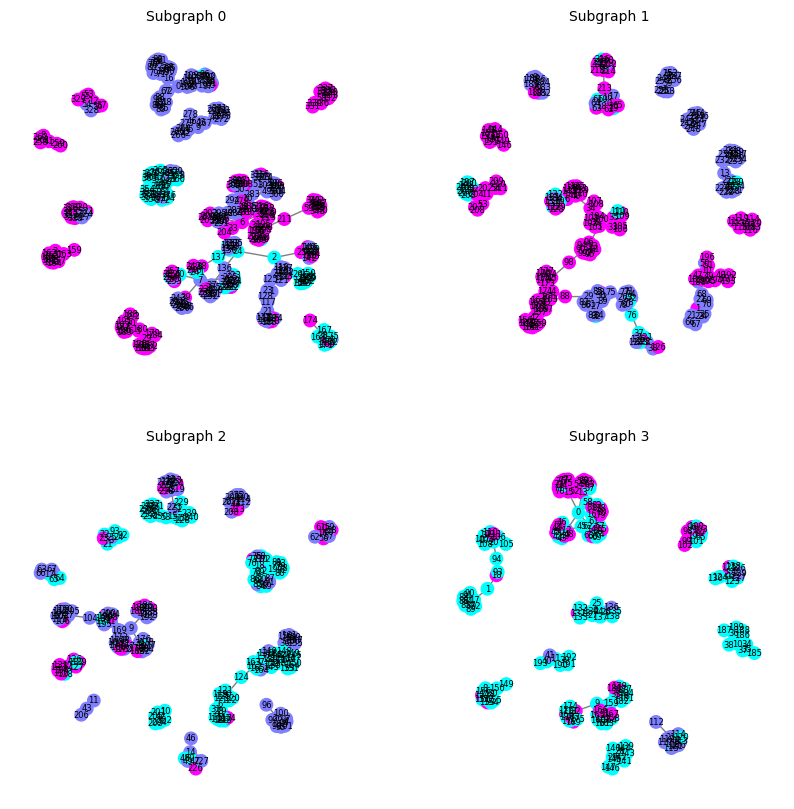

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.loader import NeighborLoader
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)
# Smaller figure size
fig = plt.figure(figsize=(10, 10))  # Reduced size

for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)

    ax = fig.add_subplot(int(str(pos)[0]), int(str(pos)[1]), int(str(pos)[2]))
    ax.set_title(f'Subgraph {idx}', fontsize=10)  # Smaller title size
    plt.axis('off')

    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=0),
        with_labels=True,
        node_size=80,  # Reduce node size
        node_color=subdata.y,
        cmap="cool",
        font_size=6,  # Reduce label size
        edge_color="gray",  # Softer edge color
    )
plt.show()


We created four subgraphs of various sizes. It allows us to process them in parallel and they’re easier to fit on a GPU since they’re smaller.

The number of neighbors is an important parameter since pruning our graph removes a lot of information. How much, exactly? Well, quite a lot. We can visualize this effect by looking at the node degrees (number of neighbors).

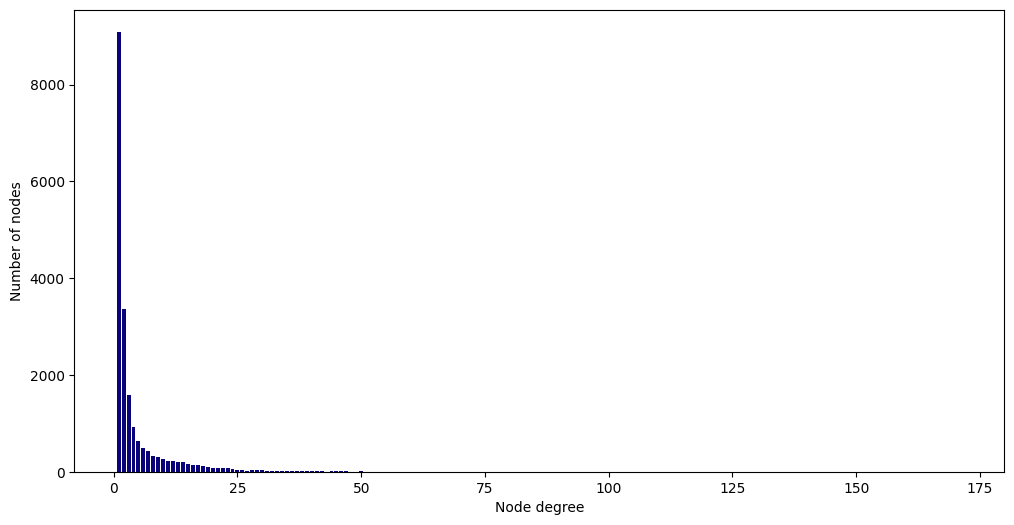

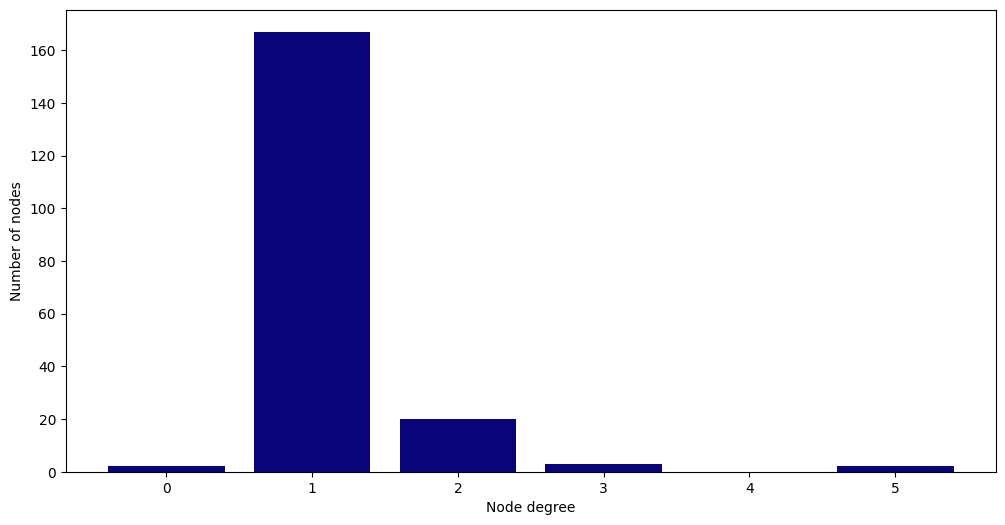

In [ ]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
  # Get list of degrees for each node
  degrees = degree(data.edge_index[0]).numpy()

  # Count the number of nodes for each degree
  numbers = Counter(degrees)

  # Bar plot
  fig, ax = plt.subplots(figsize=(12, 6))
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Number of nodes')
  plt.bar(numbers.keys(),
          numbers.values(),
          color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

The first plot shows the original distribution of node degrees, and the second one shows the distribution we obtain after neighbor sampling. In this example, we chose to only consider five neighbors, which is much lower than the original maximal value. It’s important to remember this tradeoff when talking about GraphSAGE.

We created four subgraphs of various sizes. It allows us to process them in parallel and they’re easier to fit on a GPU since they’re smaller.

The number of neighbors is an important parameter since pruning our graph removes a lot of information. How much, exactly? Well, quite a lot. We can visualize this effect by looking at the node degrees (number of neighbors).

## 2.2 Aggregate Functions
a node’s neighbors have no natural ordering; thus, the aggregator functions in Algorithm 1 must operate over an unordered set of vectors. Ideally, an aggregator function would be symmetric (i.e., invariant to permutations of its inputs) while still being trainable and maintaining high representational capacity. The symmetry property of the aggregation function ensures that our neural network model can be trained and applied to arbitrarily ordered node neighborhood feature sets. We examined three candidate aggregator functions:


- **Mean Aggregation**:
  - The paper's first candidate
  - The mean aggregator is nearly
equivalent to the convolutional propagation rule used in the transductive GCN framework. We call this modified mean-based aggregator convolutional since it is a rough, linear approximation of
a localized spectral convolution
  - $$\mathbf{h}_v^k \leftarrow \sigma\left(\mathbf{W} \cdot \textrm{MEAN}\left(\{\mathbf{h}_v^{k-1}\} \cup \{\mathbf{h}_u^{k-1}, \forall u \in \mathcal{N}(v)\}\right)\right).
$$
- **LSTM Aggregation**:
  - a more complex aggregator based on an LSTM architecture.
  - LSTMs have the advantage of larger expressive capability.
  - However, it is important to note that LSTMs are not inherently symmetric  since they process their inputs in a sequential manner. We adapt LSTMs to operate on an unordered set by simply applying the LSTMs to a random permutation of the node’s neighbors.



- **Max Pooling Aggregation**: Takes the element-wise maximum of neighboring node features.
  - both symmetric and trainable
  - each neighbor’s vector is independently fed through a fully-connected neural
network; following this transformation, an elementwise max-pooling operation is applied to aggregate
information across the neighbor set.
  - $$\text{AGGREGATE}_{k}^{\text{pool}} = \max\left(\left\{\sigma\left(\mathbf{W}_{\text{pool}}\mathbf{h}_{u_i}^{k} + \mathbf{b}\right), \forall u_i \in \mathcal{N}(v)\right\}\right),
$$





## 2.3 Learning The Parameters (Loss Function)


Since GraphSAGE can be used for both Unsupervised and Supervised tasks, we will analyze them and their loss functions seperately.

**a. Unsupervised Tasks**: In unsupervised learning, the goal is to learn node embeddings that capture the graph's structure without using labeled data. GraphSAGE achieves this by encouraging nodes that are close in the graph to have similar embeddings, while nodes that are far apart have dissimilar embeddings. This is typically done using random walks to define node proximity.
- Random Walks: For each node, perform random walks of fixed length to generate sequences of nodes. Nodes that co-occur in these sequences are considered "close."
- Negative Sampling: To enforce dissimilarity, randomly sample nodes that do not co-occur in the random walks (negative samples).

Loss Function:

The unsupervised loss function is based on negative sampling and encourages the model to:
- Maximize the similarity (dot product) of embeddings for nodes that co-occur in random walks.
- Minimize the similarity of embeddings for nodes that do not co-occur.
- $$
\begin{align*}
J_{\mathcal{G}}(\mathbf{z}_u) = -\log\left(\sigma(\mathbf{z}_u^{\top}\mathbf{z}_v)\right) - Q\cdot\mathbb{E}_{v_n\sim P_n(v)}\log\left(\sigma(-\mathbf{z}_u^{\top}\mathbf{z}_{v_n})\right),
\end{align*}
$$

**b.Supervised Tasks**:
In supervised learning, the goal is to predict labels for nodes (e.g., node classification) or edges (e.g., link prediction). The model is trained using labeled data, and the embeddings are optimized to minimize a task-specific loss function.

- Node Classification: Each node has a label, and the goal is to predict the label based on the node's embedding. Use a cross-entropy loss to measure the difference between the predicted and true labels. If the labels are binary, use binary cross-entropy loss. If the labels are multi-class, use categorical cross-entropy loss.

- Link Prediction: The goal is to predict whether an edge exists between two nodes based on their embeddings. Use a binary cross-entropy loss to predict whether an edge exists between two nodes.The input to the loss function is the dot product of the embeddings of the two nodes, passed through a sigmoid function.




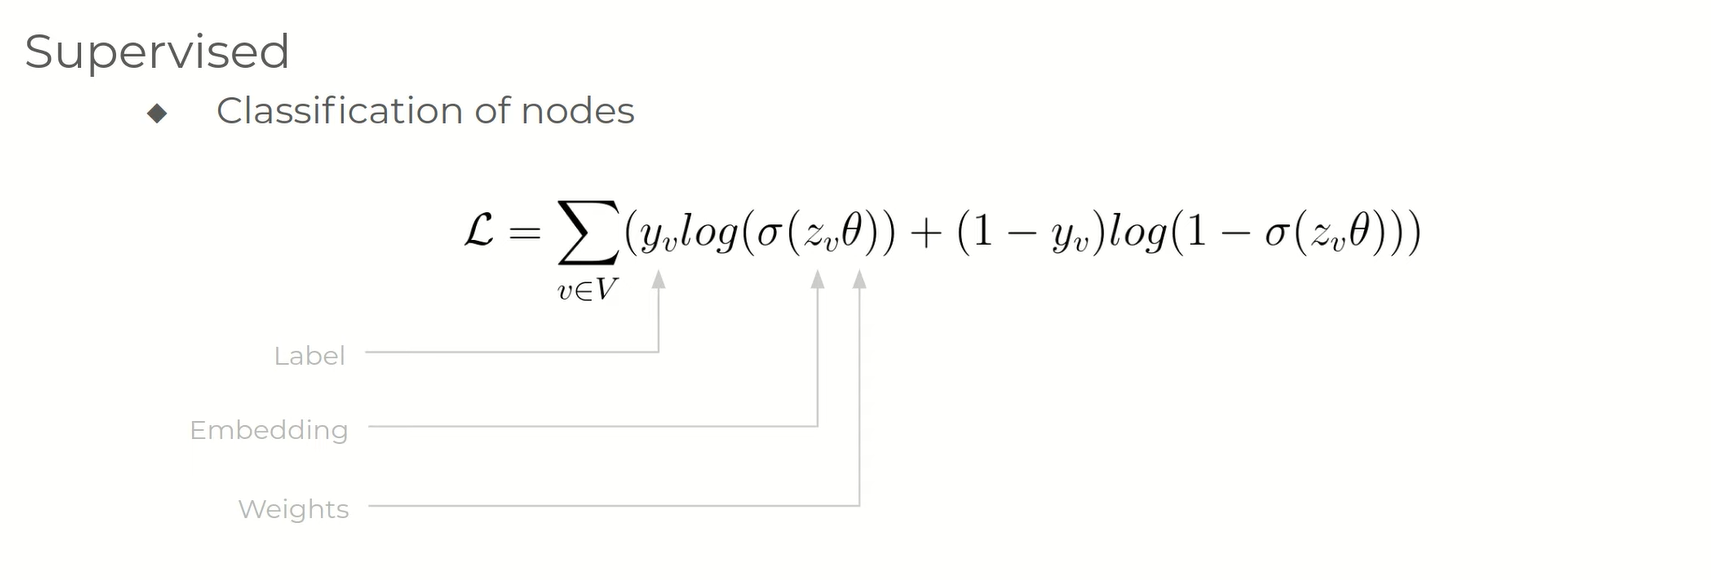

---
We can easily implement a GraphSAGE architecture in PyTorch Geometric with the `SAGEConv` layer. This implementation uses two weight matrices instead of one, like UberEats’ version of GraphSAGE:

$$
\mathbf{h}_i' = \mathbf{W}_1\mathbf{h}_i + \mathbf{W}_2 \cdot \text{mean}_{j \in N_i}(\mathbf{h}_j)
$$

Let’s create a network with two `SAGEConv` layers:

- The first one uses $ReLU$ as the activation function and a **dropout layer**;
- The second one directly outputs the **node embeddings**.

As we’re dealing with a multi-class classification task, we’ll use the cross-entropy loss as our loss function. I also added an L2 regularization of $0.0005$ for good measure.

To see the benefits of GraphSAGE, let’s compare it with a GCN and a GAT without any sampling.

In [ ]:
import torch
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv
import torch.nn.functional as F


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h) # layer 1
    self.sage2 = SAGEConv(dim_h, dim_out) # layer 2
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1),
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1),
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

@torch.no_grad()
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
%%time

# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch   0 | Train Loss: 1.129 | Train Acc:  27.39% | Val Loss: 1.10 | Val Acc: 41.39%
Epoch  10 | Train Loss: 0.092 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 78.33%
Epoch  20 | Train Loss: 0.023 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 76.05%
Epoch  30 | Train Loss: 0.027 | Train Acc: 100.00% | Val Loss: 0.52 | Val Acc: 81.75%
Epoch  40 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 0.52 | Val Acc: 78.26%
Epoch  50 | Train Loss: 0.021 | Train Acc: 100.00% | Val Loss: 0.51 | Val Acc: 82.10%
Epoch  60 | Train Loss: 0.020 | Train Acc: 100.00% | Val Loss: 0.55 | Val Acc: 73.77%
Epoch  70 | Train Loss: 0.013 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 72.50%
Epoch  80 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.43 | Val Acc: 80.06%
Epoch  90 | Train Loss: 0.016 | Train Acc: 100.00% | Val Loss: 0.73 | Val Acc: 54.55%
Epoch 100 | Train Loss: 0.027 | Train Acc: 100.00

In [ ]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, 200)

# Test
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(500, 64)
  (gcn2): GCNConv(64, 3)
)
Epoch   0 | Train Loss: 1.096 | Train Acc:  45.00% | Val Loss: 1.10 | Val Acc: 38.80%
Epoch  10 | Train Loss: 0.727 | Train Acc:  93.33% | Val Loss: 0.87 | Val Acc: 74.20%
Epoch  20 | Train Loss: 0.382 | Train Acc:  95.00% | Val Loss: 0.69 | Val Acc: 74.20%
Epoch  30 | Train Loss: 0.200 | Train Acc:  96.67% | Val Loss: 0.62 | Val Acc: 76.40%
Epoch  40 | Train Loss: 0.137 | Train Acc:  98.33% | Val Loss: 0.55 | Val Acc: 77.80%
Epoch  50 | Train Loss: 0.098 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 77.80%
Epoch  60 | Train Loss: 0.077 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.40%
Epoch  70 | Train Loss: 0.108 | Train Acc:  96.67% | Val Loss: 0.61 | Val Acc: 72.60%
Epoch  80 | Train Loss: 0.071 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 76.80%
Epoch  90 | Train Loss: 0.091 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 77.60%
Epoch 100 | Train Loss: 0.077 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 76

In [ ]:
%%time

# Create GAT
gat = GAT(dataset.num_features, 64, dataset.num_classes)
print(gat)

# Train
gat.fit(data, 200)

# Test
print(f'\nGAT test accuracy: {test(gat, data)*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(500, 64, heads=8)
  (gat2): GATv2Conv(512, 3, heads=8)
)
Epoch   0 | Train Loss: 3.215 | Train Acc:   0.00% | Val Loss: 3.23 | Val Acc: 0.60%
Epoch  10 | Train Loss: 0.712 | Train Acc:  90.00% | Val Loss: 0.87 | Val Acc: 71.60%
Epoch  20 | Train Loss: 0.387 | Train Acc:  91.67% | Val Loss: 0.66 | Val Acc: 73.20%
Epoch  30 | Train Loss: 0.183 | Train Acc:  96.67% | Val Loss: 0.60 | Val Acc: 76.60%
Epoch  40 | Train Loss: 0.118 | Train Acc:  96.67% | Val Loss: 0.63 | Val Acc: 76.20%
Epoch  50 | Train Loss: 0.098 | Train Acc:  98.33% | Val Loss: 0.62 | Val Acc: 75.80%
Epoch  60 | Train Loss: 0.078 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 77.20%
Epoch  70 | Train Loss: 0.079 | Train Acc: 100.00% | Val Loss: 0.60 | Val Acc: 76.20%
Epoch  80 | Train Loss: 0.064 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 78.00%
Epoch  90 | Train Loss: 0.065 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 75.00%
Epoch 100 | Train Loss: 0.049 | Train Acc: 100.00% | Val Lo

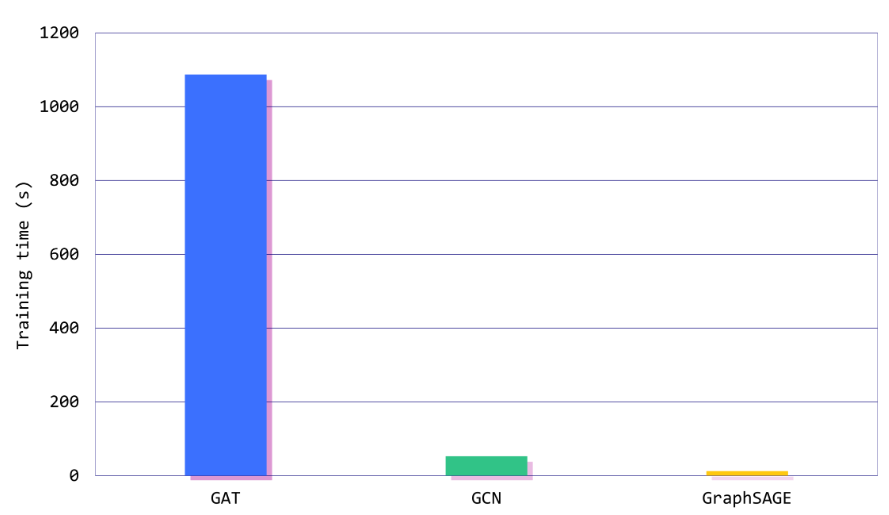